In [ ]:
#Kaggle Grandmaster youtube videos: Owen Zhang & others
#Nick's Protein folding group, beaten by  - DeepMind AlphaFold
# Granger Causality
# adversarial validation
#adversarial training
# secret naive market analysis:
# flow rate (m^3/sec)
# Pc: casing pressure
# Pt: tubing pressure
# Pl: line pressure
# ro = Pc - Pt/Pc - Pl: ratio1
# Pc/Pt: ratio2
# Bryan used to look at the derivatives of each of these (flow rate, Pc, Pt, Pl, ratio1 and ratio 2)
# he set threshold of what defined stable for each of these, just taking first derivative

In [54]:
import pandas as pd # read_csv, datetime, DataFrame
import numpy as np # random.normal, sin

from pandas.plotting import autocorrelation_plot as auto_corr

from matplotlib import pyplot as plt # for plotting
import seaborn as sns; sns.set() # for prettier plots / formatting / style

# jupyter cell magic for inline visualization
%matplotlib inline 

# tsa : time series analysis
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose as season
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# metrics
from sklearn import metrics # explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
#from sklearn.utils import check_arrays # converts list-like objects to array (if needed)

from sklearn.model_selection import train_test_split
# scikit-learn models
from sklearn.linear_model import LinearRegression as LinReg

In [25]:
SIZE = (10,6)

In [2]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.figure(figsize=SIZE)
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [3]:
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    print("MAPE:\n\t", MAPE(y_true, y_pred))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))

In [263]:
data = pd.read_csv("zillow_data.csv") #parse_dates=['Month'], index_col=['Month']
data.head(20)
data_ts = data.iloc[:,8:]
data_ts.index = data["RegionID"]
data_ts = data_ts.T

In [264]:
data_ts.index = pd.to_datetime(data_ts.index)


In [265]:
data_ts.head()


RegionID,84654,90668,91982,84616,93144,91733,61807,84640,91940,97564,...,59187,94711,62556,99032,62697,58333,59107,75672,93733,95851
1996-05-01,335400.0,236900.0,212200.0,500900.0,77300.0,95200.0,152700.0,216700.0,95600.0,771100.0,...,80100.0,136300.0,78300.0,136600.0,62600.0,94300.0,92500.0,57300.0,192400.0,176300.0
1996-06-01,336500.0,236700.0,212200.0,503100.0,77300.0,95400.0,152600.0,216900.0,95800.0,776500.0,...,79400.0,136600.0,78200.0,136800.0,62700.0,94000.0,92400.0,57500.0,193700.0,176100.0
1996-07-01,337600.0,235400.0,210700.0,504600.0,77300.0,95700.0,152400.0,217000.0,96100.0,781900.0,...,78600.0,136900.0,78200.0,136800.0,62700.0,93700.0,92200.0,57700.0,195000.0,176000.0
1996-08-01,338500.0,233300.0,208300.0,505500.0,77400.0,95900.0,152300.0,217100.0,96400.0,787300.0,...,77900.0,137100.0,78100.0,136700.0,62700.0,93400.0,92100.0,58000.0,196300.0,175900.0
1996-09-01,339500.0,230600.0,205500.0,505700.0,77500.0,96100.0,152000.0,217200.0,96700.0,793000.0,...,77200.0,137400.0,78000.0,136600.0,62600.0,93200.0,91900.0,58200.0,197700.0,175800.0


In [267]:
data_ts['month']= data_ts.index.month
data_ts['year']= data_ts.index.year
data_ts.head()

RegionID,84654,90668,91982,84616,93144,91733,61807,84640,91940,97564,...,62556,99032,62697,58333,59107,75672,93733,95851,month,year
1996-05-01,335400.0,236900.0,212200.0,500900.0,77300.0,95200.0,152700.0,216700.0,95600.0,771100.0,...,78300.0,136600.0,62600.0,94300.0,92500.0,57300.0,192400.0,176300.0,5,1996
1996-06-01,336500.0,236700.0,212200.0,503100.0,77300.0,95400.0,152600.0,216900.0,95800.0,776500.0,...,78200.0,136800.0,62700.0,94000.0,92400.0,57500.0,193700.0,176100.0,6,1996
1996-07-01,337600.0,235400.0,210700.0,504600.0,77300.0,95700.0,152400.0,217000.0,96100.0,781900.0,...,78200.0,136800.0,62700.0,93700.0,92200.0,57700.0,195000.0,176000.0,7,1996
1996-08-01,338500.0,233300.0,208300.0,505500.0,77400.0,95900.0,152300.0,217100.0,96400.0,787300.0,...,78100.0,136700.0,62700.0,93400.0,92100.0,58000.0,196300.0,175900.0,8,1996
1996-09-01,339500.0,230600.0,205500.0,505700.0,77500.0,96100.0,152000.0,217200.0,96700.0,793000.0,...,78000.0,136600.0,62600.0,93200.0,91900.0,58200.0,197700.0,175800.0,9,1996


In [270]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


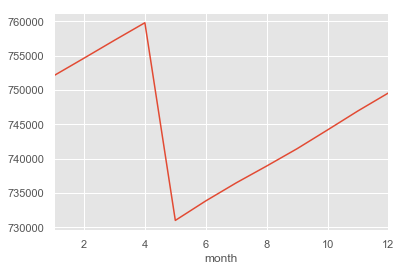

In [269]:
data_ts.groupby('month').mean()[84654].plot()

In [256]:
chi_data = data[data.Metro == 'Chicago']
chi_data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


In [271]:
del data['RegionID']; del data['RegionName']; del data['City']; del data['State']; del data['CountyName']; del data['SizeRank']

In [272]:
clean = data.dropna()

In [273]:
data.T.head()

,0,1,2,3,4,5,6,7,8,9,...,14713,14714,14715,14716,14717,14718,14719,14720,14721,14722
Metro,Chicago,Dallas-Fort Worth,Houston,Chicago,El Paso,Houston,New York,Chicago,Houston,San Francisco,...,Claremont,St. George,Kingston,Portland,NaN,Greenfield Town,Claremont,Richmond,NaN,Las Vegas
1996-04,334200,235700,210400,498100,77300,95000,152900,216500,95400,766000,...,80800,135900,78300,136200,62500,94600,92700,57100,191100,176400
1996-05,335400,236900,212200,500900,77300,95200,152700,216700,95600,771100,...,80100,136300,78300,136600,62600,94300,92500,57300,192400,176300
1996-06,336500,236700,212200,503100,77300,95400,152600,216900,95800,776500,...,79400,136600,78200,136800,62700,94000,92400,57500,193700,176100
1996-07,337600,235400,210700,504600,77300,95700,152400,217000,96100,781900,...,78600,136900,78200,136800,62700,93700,92200,57700,195000,176000


In [45]:
clean.shape


(12895, 272)

In [32]:
#Sort by one region at a time
first_region_info = clean[clean.iloc[2].index[:7]].iloc[2]
first_dates = clean[clean.iloc[2].index[7:]].iloc[2]
first_region_info.head()

RegionID        91982
RegionName      77494
City             Katy
State              TX
Metro         Houston
Name: 2, dtype: object

In [40]:
first_dates = clean[clean.iloc[2].index[7:]].iloc[2].index.dtype
first_dates

dtype('O')

In [43]:
#ACF & PACF plots
def plot_lag(data, nlags):
    lag_acf = acf(data, nlags=nlags)
    lag_pacf = pacf(data, nlags=nlags, method='ols')

    plt.figure(figsize=(20,6))
    #Plot ACF:
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='green')
    plt.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='red')
    plt.title('ACF')            

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='green')
    plt.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='red')
    plt.title('PACF')

    plt.tight_layout()
    plt.show()

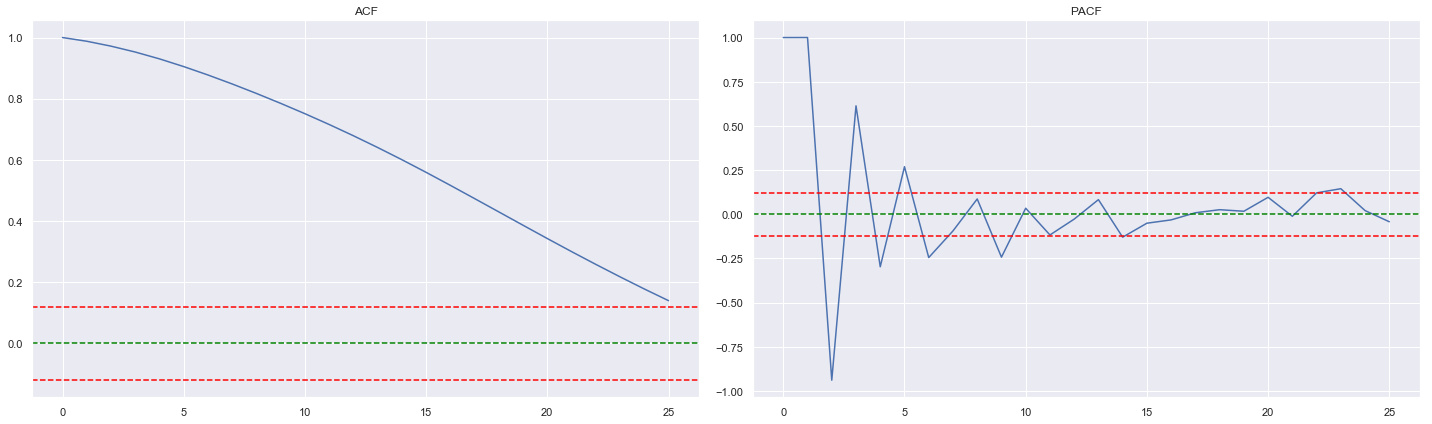

In [33]:
#ACF & PACF plots

lag_acf = acf(first_dates, nlags=25)
lag_pacf = pacf(first_dates, nlags=25, method='ols')

plt.figure(figsize=(20,6))
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='green')
plt.axhline(y=-1.96/np.sqrt(len(first_dates)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(first_dates)), linestyle='--', color='red')
plt.title('ACF')            

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='green')
plt.axhline(y=-1.96/np.sqrt(len(first_dates)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(first_dates)), linestyle='--', color='red')
plt.title('PACF')
            
plt.tight_layout()
plt.show()

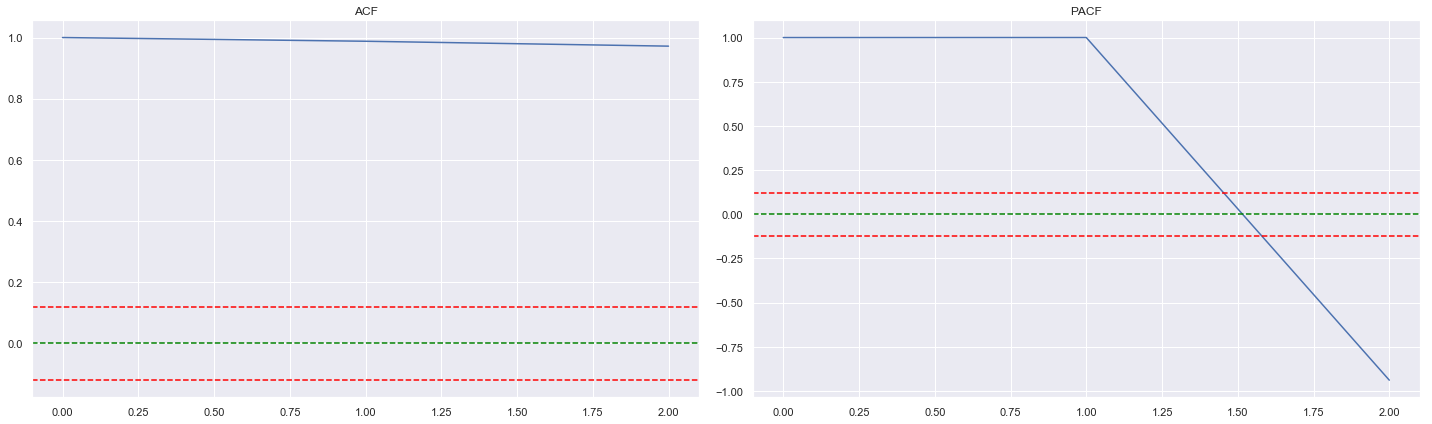

In [44]:
plot_lag(clean[clean.iloc[2].index[7:]].iloc[2], 2)

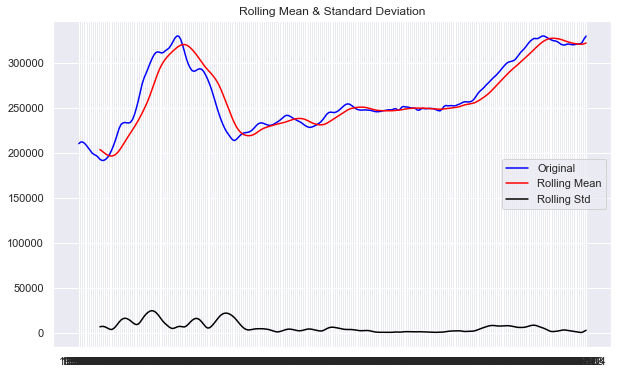

Results of Dickey-Fuller Test:
Test Statistic                  -2.504919
p-value                          0.114282
#Lags Used                       8.000000
Number of Observations Used    256.000000
Critical Value (1%)             -3.456155
Critical Value (5%)             -2.872897
Critical Value (10%)            -2.572822
dtype: float64


In [34]:
test_stationarity(first_dates)

In [85]:
# df = pd.DataFrame(t, columns=['t'])
# df['x'] = x
cutat = int(7 + (len(clean)-7)*.75)
print(cutat, clean.shape)
first_datestest = clean[clean.iloc[2].index[7:]].iloc[2]
clean_train_df = clean.iloc[:,7:cutat]
clean_test_df = clean.iloc[:,cutat:]

9673 (12895, 274)


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#y is the price, clean[clean.iloc[i].index[7:]].iloc[i],
#what would x be? the dates AKA the columns that contain each of those prices?

NameError: name 'X' is not defined

In [82]:
clean_test_df.head()

""
0
1
2
3
4


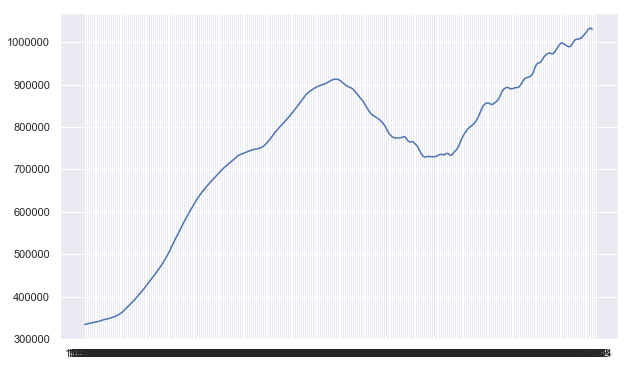

In [83]:
plt.figure(figsize=SIZE)
# clean.train.plot()
# clean.test.plot()
plt.plot(clean_train_df.iloc[0])
plt.plot(clean_test_df.iloc[0])
plt.show()

In [94]:
!tar -xf df_09.tar

In [239]:
df09 = pd.read_csv('df_09.csv')
df09 = pd.to_datetime(df09.iloc[:,8:], format='%Y-%m')
# df09.head()
#splitting off the last 3 years from the '09 DF for row 0 (Chicago) to get a single row SARIMA model working
ex_01 = df09[df09.iloc[0].index[-38:]].iloc[0]#.diff(axis=1).dropna()
ex_01 = pd.DataFrame(ex_01).diff().dropna()
ex_01.index
# temp_data = pd.read_csv("min_temp.csv", parse_dates=['Date'], index_col=['Date'])

ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

In [99]:
lag=1

In [186]:
#Why all the Nans here?


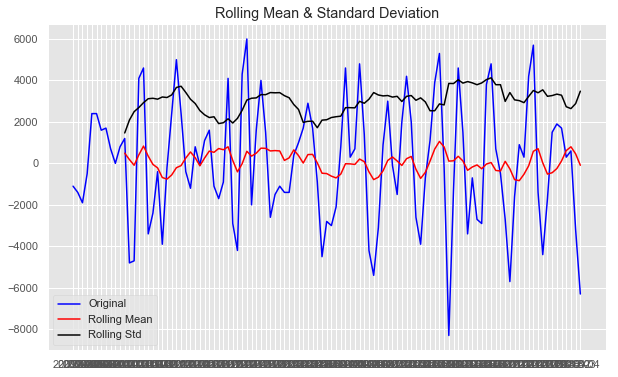

Results of Dickey-Fuller Test:
Test Statistic                -6.297887e+00
p-value                        3.469633e-08
#Lags Used                     6.000000e+00
Number of Observations Used    1.020000e+02
Critical Value (1%)           -3.496149e+00
Critical Value (5%)           -2.890321e+00
Critical Value (10%)          -2.582122e+00
dtype: float64


In [126]:
ex_0 = df09.iloc[:,8:].diff(lag, axis=1).iloc[0].dropna()

test_stationarity(ex_0)ex_01

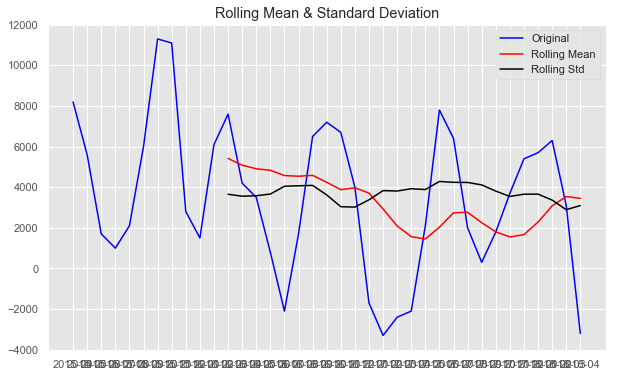

Results of Dickey-Fuller Test:


ValueError: too many values to unpack (expected 2)

In [197]:
test_stationarity(ex_01)

In [127]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

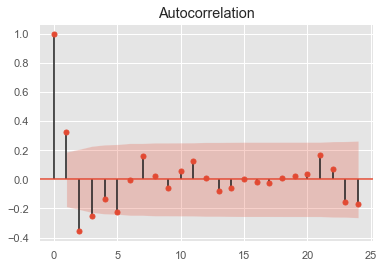

In [136]:
plot_acf(ex_0, lags=24)
plt.show()

In [137]:
q_list = [0,1,2,3]

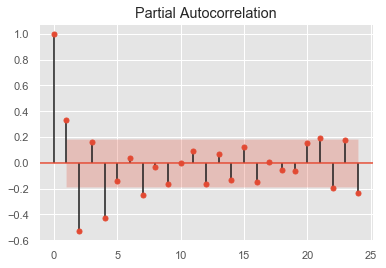

In [135]:
plot_pacf(ex_0, lags=24)
plt.show()

In [138]:
p_list = [0,1,2,4,7]

# d=2

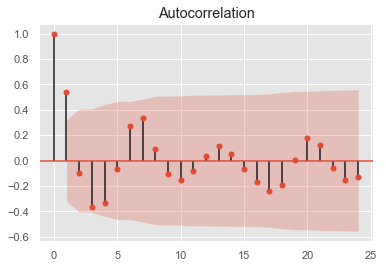

In [202]:
plot_acf(ex_01, lags=24)
plt.show()

In [205]:
q_list = [0,1]

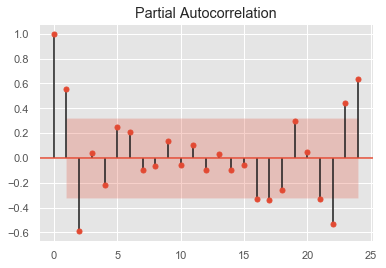

In [203]:
plot_pacf(ex_01, lags=24)
plt.show()

In [206]:
p_list = [0,1,2]

In [107]:
#only prices of DF from '09 to the end
df09q = df09.iloc[:,8:]

In [113]:
# Import necessary libraries
from numba import jit
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')


In [199]:
def zipcodecolumns_datetimeindex(df):
    df_zipcode = df.set_index(df["RegionName"])
    df_zipcode = df_zipcode.drop(columns=["RegionID", "RegionName", 
                                          "City", "State", "Metro", 
                                          "CountyName", "SizeRank"])
    df_datetime = df_zipcode.transpose()
    df_datetime.index = pd.to_datetime(df_datetime.index)
    return df_datetime

In [201]:
ex_01.head()

,0
2015-04,8200.0
2015-05,5600.0
2015-06,1700.0
2015-07,1000.0
2015-08,2100.0


In [111]:
#how can I get the 120 columns from df09.iloc[:,8:] to be my datetime index?
df09q = pd.to_datetime(df09q)
df09q.set_index('Date', inplace=True)

# Plot the time-series
df09q.plot(figsize=(15, 6))
plt.show()
print(df09q.head())


ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

In [210]:
# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

# Fit an ARMA(2,1) model to the first simulated data
mod_arma = ARMA(ex_01, order=(1,2))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

# Print out the estimate for the constant and for theta
print(res_arma.params)

                              ARMA Model Results                              
Dep. Variable:                      0   No. Observations:                   37
Model:                     ARMA(1, 2)   Log Likelihood                -332.173
Method:                       css-mle   S.D. of innovations           1734.356
Date:                Tue, 18 Jun 2019   AIC                            674.346
Time:                        11:46:11   BIC                            682.400
Sample:                    04-01-2015   HQIC                           677.185
                         - 04-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3296.2028   1135.550      2.903      0.007    1070.565    5521.841
ar.L1.0        0.1106      0.175      0.633      0.531      -0.232       0.453
ma.L1.0        1.6441      0.120     13.726      0.0

In [213]:
# Fit an ARMA(2,1) model to the first simulated data
mod_arma = ARMA(ex_01, order=(1,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

# Print out the estimate for the constant and for theta
print(res_arma.params)

                              ARMA Model Results                              
Dep. Variable:                      0   No. Observations:                   37
Model:                     ARMA(1, 0)   Log Likelihood                -349.349
Method:                       css-mle   S.D. of innovations           3031.586
Date:                Tue, 18 Jun 2019   AIC                            704.698
Time:                        12:01:28   BIC                            709.530
Sample:                    04-01-2015   HQIC                           706.401
                         - 04-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3420.3253   1204.349      2.840      0.007    1059.845    5780.805
ar.L1.0        0.6019      0.139      4.326      0.000       0.329       0.875
                                    Roots           

In [153]:
# Define the p, d and q parameters to take any value between 0 and 2
# p = d = q = range(0, 2)
d = range(2,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p_list, d, q_list))

# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p_list, d, q_list))]

In [162]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(ex_0,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [161]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

TypeError: reduction operation 'argmin' not allowed for this dtype

In [157]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ex_0,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3451      0.277     -1.245      0.213      -0.888       0.198
ma.L1          0.6910      0.207      3.333      0.001       0.285       1.097
ar.S.L12      -0.1384      0.195     -0.711      0.477      -0.520       0.243
ma.S.L12      -1.2095      0.098    -12.355      0.000      -1.401      -1.018
sigma2      8.313e+06   1.58e-08   5.27e+14      0.000    8.31e+06    8.31e+06


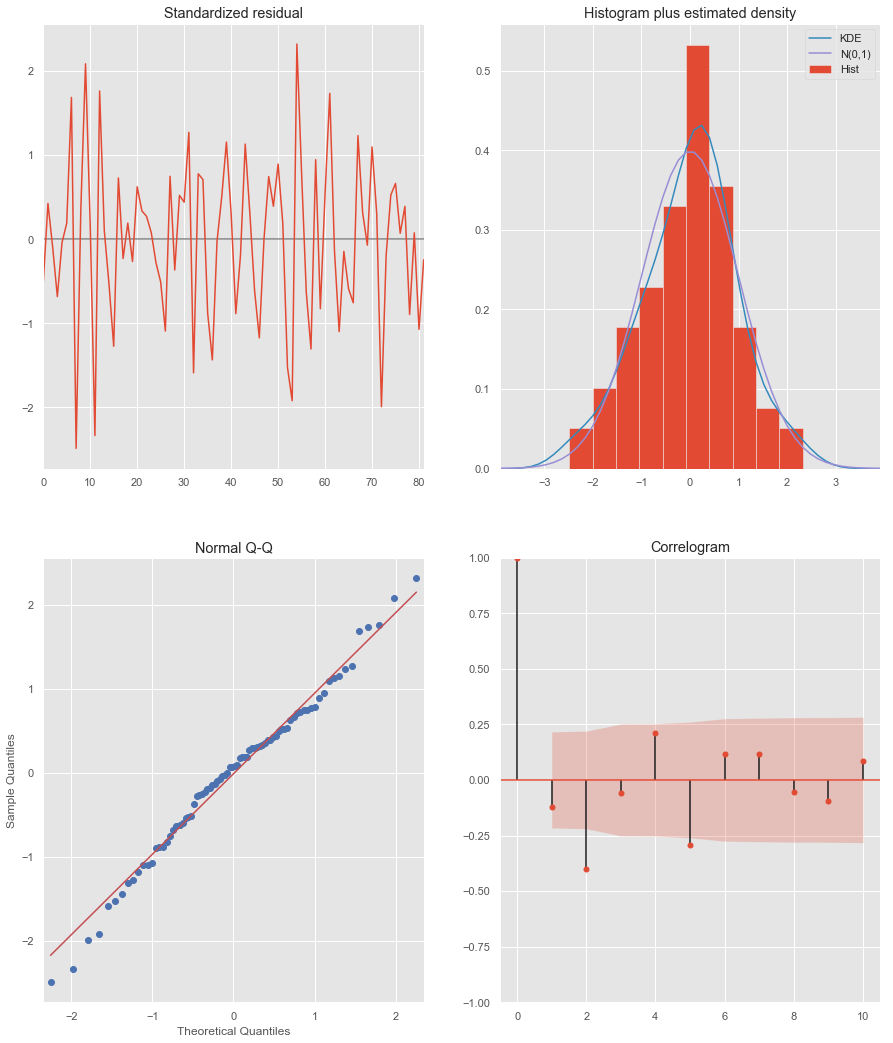

In [214]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
pred = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = CO2['1990':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [ ]:
# Get the Real and predicted values
CO2_forecasted = pred.predicted_mean
CO2_truth = CO2['1998-01-01':]

# Compute the mean square error
mse = ((CO2_forecasted - CO2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The Mean Squared Error of our forecasts is 0.07

In [ ]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
# Plot the dynamic forecast with confidence intervals.

ax = CO2['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), CO2_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [ ]:
# Extract the predicted and true values of our time series
CO2_forecasted = pred_dynamic.predicted_mean
CO2_truth = CO2['1998-01-01':]

# Compute the mean square error
mse = ((CO2_forecasted - CO2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The Mean Squared Error of our forecasts is 1.01

In [ ]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

In [ ]:
# Plot future predictions with confidence intervals

ax = CO2.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()